In [1]:
import pandas as pd
import configparser
import numpy as np
from datetime import datetime
import dateutil.relativedelta
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import preprocessing

from scipy import stats
# Regular expressions
import re
#import sweetviz
# seaborn : advanced visualization
import seaborn as sns
print('seaborn version\t:',sns.__version__)
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None #set it to None to remove SettingWithCopyWarning
pd.options.display.float_format = '{:.4f}'.format #set it to convert scientific noations such as 4.225108e+11 to 422510842796.00
pd.set_option('display.max_columns', None) # to display all the columns

from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from category_encoders.one_hot import OneHotEncoder

np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format})

from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"

import platform
from platform import python_version
import jupyterlab
print("System")
print("os name: %s" % os.name)
print("system: %s" % platform.system())
print("release: %s" % platform.release())
print()
print("Python")
print("version: %s" % python_version())
print()
print("Python Packages")
print("jupterlab==%s" % jupyterlab.__version__)
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
from sklearn.metrics import mean_squared_error

seaborn version	: 0.11.1
System
os name: nt
system: Windows
release: 10

Python
version: 3.8.8

Python Packages
jupterlab==3.0.14
pandas==1.2.4
numpy==1.20.1


## Data Import

In [2]:
## Importing SQLite Libraries
import sqlite3
from sqlite3 import Error
from matplotlib.gridspec import GridSpec

In [3]:
## Creating function to connect DB and execute SQL query
def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows
# Delete old database file



In [4]:
## Connecting to DB
normalized_database_filename = 'Project_DB.db'
conn = create_connection(normalized_database_filename, delete_db=False)

In [5]:
## Importing Data into SQL tables
def create_sales_table(data_filename, normalized_database_filename):
    # Inputs: Name of the data and normalized database filename
    # Output: None
    sales_data=[]
    header=True
    with open(data_filename,'r') as f: #we open the file in 'read' mode. The 'with' clause is similar to 'finally' clause
        for line in f: #iterate over the file line by line
            s = line.strip() #strip() removes the endline character at the end of the line. Line is of type 'st
            #print(s)
            if header:
                header=False
                continue
            data=s.split(',')
            sales_data.append(tuple([data[0].strip(),data[1].strip(),data[2].strip(),data[3].strip(),data[4].strip()\
                                     ,data[5].strip(),data[6].strip(),data[7]]))
    conn = create_connection(normalized_database_filename)
    create_table_sql="CREATE TABLE  Sales_Table(Store  INTEGER NOT NULL,  Date TEXT NOT NULL,Weekly_Sales REAL, \
                        Holiday_Flag INTEGER,Temperature REAL, Fuel_Price REAL, CPI REAL,Unemployment REAL );"          
    create_table(conn, create_table_sql,drop_table_name='Sales_Table')  
    

######### ## Populating Sales table ##############

    sales_data.sort(key=lambda x: (x[0]))
    #print(rows[1:4],len(rows))
    conn = create_connection(normalized_database_filename)
    sqlite_insert_query = "INSERT INTO Sales_Table (Store,Date,Weekly_Sales,Holiday_Flag,Temperature, Fuel_Price,CPI,Unemployment)\
                            VALUES (?,?,?,?,?,?,?,?);"
    cursorObj = conn.cursor()
    cursorObj.executemany(sqlite_insert_query, sales_data)
    conn.commit()

In [6]:
## Importing Data into SQL tables
normalized_database_filename = 'Project_DB.db'
data_filename = 'C:\\Users\\npand\\OneDrive\\Desktop\\MS_Course\\ES503\\Project_Doc\\Walmart_Store_sales.csv'
create_sales_table(data_filename, normalized_database_filename)

In [7]:
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM Sales_Table LIMIT 10""", conn)
df

Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010  1643690.9000             0      42.3100      2.5720   
1      1  12-02-2010  1641957.4400             1      38.5100      2.5480   
2      1  19-02-2010  1611968.1700             0      39.9300      2.5140   
3      1  26-02-2010  1409727.5900             0      46.6300      2.5610   
4      1  05-03-2010  1554806.6800             0      46.5000      2.6250   
5      1  12-03-2010  1439541.5900             0      57.7900      2.6670   
6      1  19-03-2010  1472515.7900             0      54.5800      2.7200   
7      1  26-03-2010  1404429.9200             0      51.4500      2.7320   
8      1  02-04-2010  1594968.2800             0      62.2700      2.7190   
9      1  09-04-2010  1545418.5300             0      65.8600      2.7700   

       CPI  Unemployment  
0 211.0964        8.1060  
1 211.2422        8.1060  
2 211.2891        8.1060  
3 211.3196        8.1060  
4 211.3501        8.1060  
5 211.3806        8.1060  
6 211.2156        8.1060  
7 211.0180        8.1060  
8 210.8204        7.8080  
9 210.6229        7.8080

## Data Analysis or EDA using SQL query 

In [8]:
## Store which has Max Sales
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT Store, sum(Weekly_Sales) as Total_Sales FROM Sales_Table group by Store order by Total_Sales desc LIMIT 1""", conn)
df

#Store 20 has max total sale

df = pd.read_sql_query("""SELECT Store, date,max(Weekly_Sales) as Max_weekly_Sales FROM Sales_Table order by Max_weekly_Sales desc LIMIT 1""", conn)
df
#Store 14 has max weekly sale on X-Mas eve week

Store    Total_Sales
0     20 301397792.4600

Store        Date  Max_weekly_Sales
0     14  24-12-2010      3818686.4500

In [9]:
## Store which has maximum average and max standard deviation
import math

class StdevFunc:
    def __init__(self):
        self.M = 0.0
        self.S = 0.0
        self.k = 1
 
    def step(self, value):
        if value is None:
            return
        tM = self.M
        self.M += (value - tM) / self.k
        self.S += (value - tM) * (value - self.M)
        self.k += 1
 
    def finalize(self):
        if self.k < 3:
            return None
        return math.sqrt(self.S / (self.k-2))
with sqlite3.connect(normalized_database_filename) as con:
 
    con.create_aggregate("stdev", 1, StdevFunc)
 
    cur = con.cursor()
    cur.execute("SELECT Store, avg(Weekly_Sales) as Sales_Variance FROM Sales_Table group by Store order by Sales_Variance desc")
    print(f"Store {cur.fetchone()[0]} with max avg of: {cur.fetchone()[1]:.0f}" )
    cur.execute("SELECT Store, stdev(Weekly_Sales) as Sales_Variance FROM Sales_Table group by Store order by Sales_Variance desc")
    print(f"Store {cur.fetchone()[0]} with max variance of: {cur.fetchone()[1]:.0f}" )


Store 20 with max avg of: 2094713


Store 14 with max variance of: 302262


In [10]:
## Max Growth rate in Q4


df = pd.read_sql_query("""SELECT Store, \
'Q' || COALESCE(NULLIF((SUBSTR(Date, 4, 2) - 1) / 3, 0), 4) AS Quarter,sum(Weekly_Sales) as Curr_Quarter_Sale,\
lag(sum(Weekly_Sales),1,0) over (partition by store) as Prev_Quarter_Sale,\
100*(sum(Weekly_Sales)-lag(sum(Weekly_Sales),1,0) over (partition by store))/lag(sum(Weekly_Sales),1,0) over (partition by store) as Growth
                     FROM Sales_Table where SUBSTR(Date, 7, 4)='2012' group by Store, Quarter order by growth desc Limit 1""", conn)
df

# #Store 7 has max growth rate achieved in Q4 



Store Quarter  Curr_Quarter_Sale  Prev_Quarter_Sale   Growth
0      7      Q4       7792647.2100       2021262.6000 285.5336

In [11]:
## Holiday effect on stores


df = pd.read_sql_query("""SELECT Distinct date as Day FROM Sales_Table a where a.holiday_flag=1 \
and weekly_sales < (select avg(weekly_sales) from sales_table b where b.holiday_flag=0) order by substr(Day,6),substr(Day,4,2)""", conn)
df

# Some stores shows negative impact on 4 holidays Super Bowl , Labour Day, Thanksgiving and X-Max time



Day
0  12-02-2010
1  10-09-2010
2  26-11-2010
3  31-12-2010
4  11-02-2011
5  09-09-2011
6  25-11-2011
7  30-12-2011
8  10-02-2012
9  07-09-2012

## Data Visualization  using Plot and Graphs

<Figure size 1440x576 with 0 Axes>

NumExpr defaulting to 8 threads.


<AxesSubplot:xlabel='Week'>

<AxesSubplot:xlabel='Week'>

<AxesSubplot:xlabel='Week'>

([<matplotlib.axis.XTick at 0x1ff45ab3f70>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Average Weekly Sales - Per Year')

Text(0, 0.5, 'Sales')

Text(0.5, 0, 'Week')

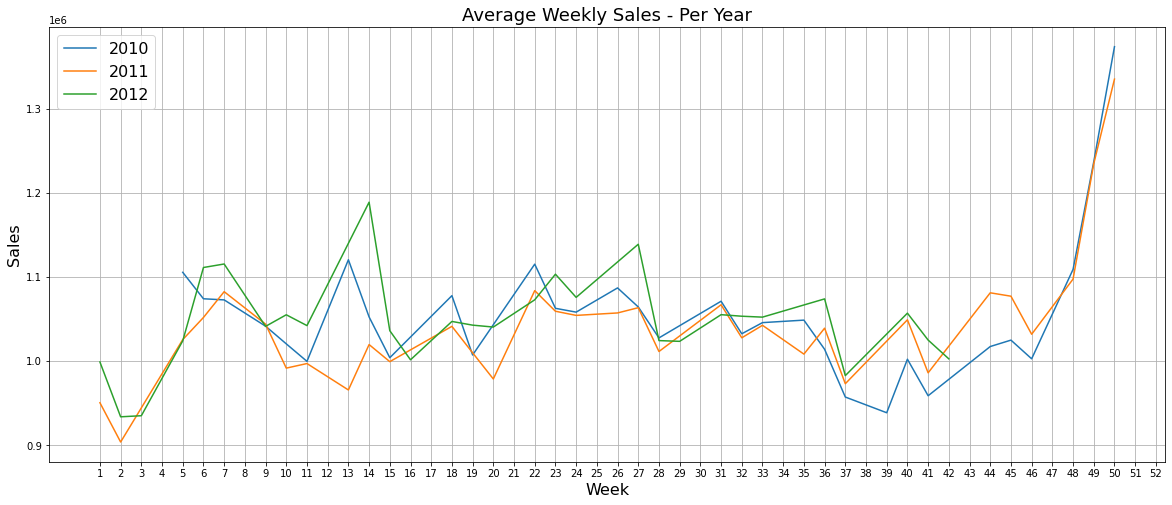

In [12]:
## Average Weekly sales for year 2010,2011 and 2012 
df_train = pd.read_sql_query("""SELECT substr(Date,7) as Year, Weekly_Sales,\
strftime('%W',(date(substr(Date,7) || '-' || substr(Date,4,2) || '-' || substr(Date,1,2)))) as Week \
FROM Sales_Table where Date <= '2012-11-01' order by Year, Week""", conn)
df_train['Week']=df_train['Week'].apply(lambda x:int(x))

weekly_sales_2010 = df_train[df_train.Year=='2010']['Weekly_Sales'].groupby(df_train['Week']).mean().sort_index()
weekly_sales_2011 = df_train[df_train.Year=='2011']['Weekly_Sales'].groupby(df_train['Week']).mean().sort_index()
weekly_sales_2012 = df_train[df_train.Year=='2012']['Weekly_Sales'].groupby(df_train['Week']).mean().sort_index()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

## Each years sales is following a similar trend 

<Figure size 1800x576 with 0 Axes>

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<AxesSubplot:xlabel='Year_Mon'>

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<AxesSubplot:xlabel='Year_Mon'>

Text(0.5, 1.0, 'Weekly Sales - Mean and Median')

Text(0, 0.5, 'Sales')

Text(0.5, 0, 'Date')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

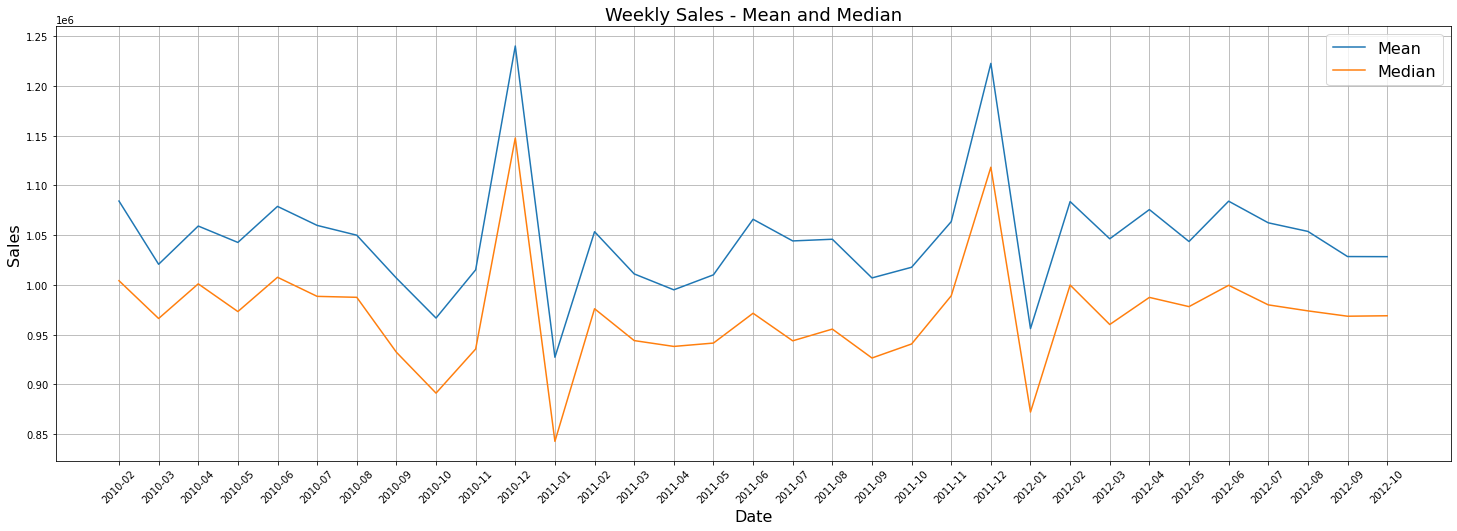

In [13]:
## DIfference in Mean and Median over the years
df_train = pd.read_sql_query("""SELECT substr(Date,7) as Year, Weekly_Sales,\
(substr(Date,7) || '-' || substr(Date,4,2)) as Year_Mon \
FROM Sales_Table where Date <= '2012-11-01' order by Year_Mon """, conn)

weekly_sales_mean = df_train['Weekly_Sales'].groupby(df_train['Year_Mon']).mean()
weekly_sales_median = df_train['Weekly_Sales'].groupby(df_train['Year_Mon']).median()
plt.figure(figsize=(25,8))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)
plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.xticks(rotation=45)
plt.show()

## The mean and the median are very different, suggesting that some stores might sell much more than others.

<Figure size 1440x576 with 0 Axes>

<AxesSubplot:xlabel='Store'>

Text(0.5, 1.0, 'Average Sales - per Store')

Text(0, 0.5, 'Sales')

Text(0.5, 0, 'Store')

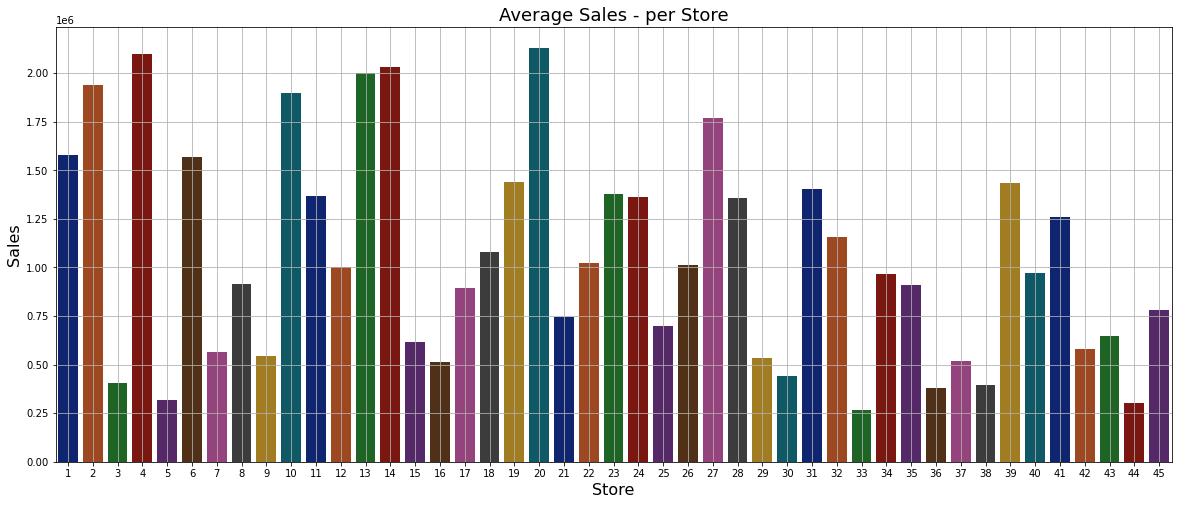

In [14]:
## AVerage sales per store 
df_train = pd.read_sql_query("""SELECT store, Weekly_Sales \
FROM Sales_Table where Date <= '2012-11-01' order by store """, conn)

weekly_sales = df_train['Weekly_Sales'].groupby(df_train['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

## There are Sales difference between the Stores. Store 4,13,14 and 20 have the highest sale

## Feature Engineering 

In [15]:
## Checking distrinution of different features and correlation to the sales
from scipy.special import boxcox1p
def make_discrete_plot(feature):
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    sns.boxplot(y=df_train.Weekly_Sales, x=df_train[feature], ax=fig.add_subplot(gs[0,0]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    sns.stripplot(y=df_train.Weekly_Sales, x=df_train[feature], ax=fig.add_subplot(gs[0,1]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    fig.show()
def make_continuous_plot(feature):
    
    fig = plt.figure(figsize=(18,15))
    gs = GridSpec(2,2)
    
    j = sns.scatterplot(y=df_train['Weekly_Sales'], 
                        x=df_train[feature], ax=fig.add_subplot(gs[0,0]), color = 'red')

    plt.title('Linear\n' + 'Corr: ' + str(np.round(df_train['Weekly_Sales'].corr(df_train[feature]),2)) + ', Skew: ' + 
               str(np.round(stats.skew(df_train[feature], nan_policy='omit'),2)))
    
    j = sns.scatterplot(y=df_train['Weekly_Sales'], 
                        x=boxcox1p(df_train[feature], 0.10), ax=fig.add_subplot(gs[0,1]), palette = 'blue')
    
    plt.title('BoxCox 0.10\n' + 'Corr: ' + str(np.round(df_train['Weekly_Sales'].corr(boxcox1p(df_train[feature], 0.10)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(df_train[feature], 0.10), nan_policy='omit'),2)))
    
    
    j = sns.scatterplot(y=df_train['Weekly_Sales'], 
                        x=boxcox1p(df_train[feature], 0.25), ax=fig.add_subplot(gs[1,0]), palette = 'blue')
    
    plt.title('BoxCox 0.25\n' + 'Corr: ' + str(np.round(df_train['Weekly_Sales'].corr(boxcox1p(df_train[feature], 0.25)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(df_train[feature], 0.25), nan_policy='omit'),2)))
    
    j = sns.distplot(df_train[feature], ax=fig.add_subplot(gs[1,1]), color = 'green')

    plt.title('Distribution\n')
    

    
    fig.show()    

In [16]:
## Fetching the data from DB
df_train = pd.read_sql_query("""SELECT store, Weekly_Sales, Holiday_Flag, Temperature, CPI, Unemployment,Fuel_Price
FROM Sales_Table where Date <= '2012-11-01' order by store """, conn)


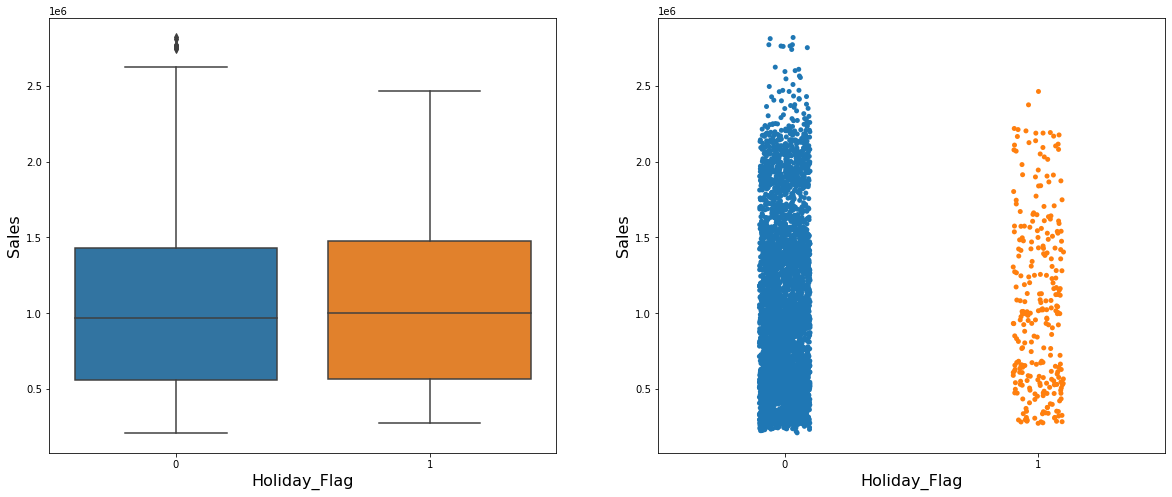

In [17]:
make_discrete_plot('Holiday_Flag')

##This field may not be important as we can see, Holiday-weeks have similar sales as non-Holiday Weeks.

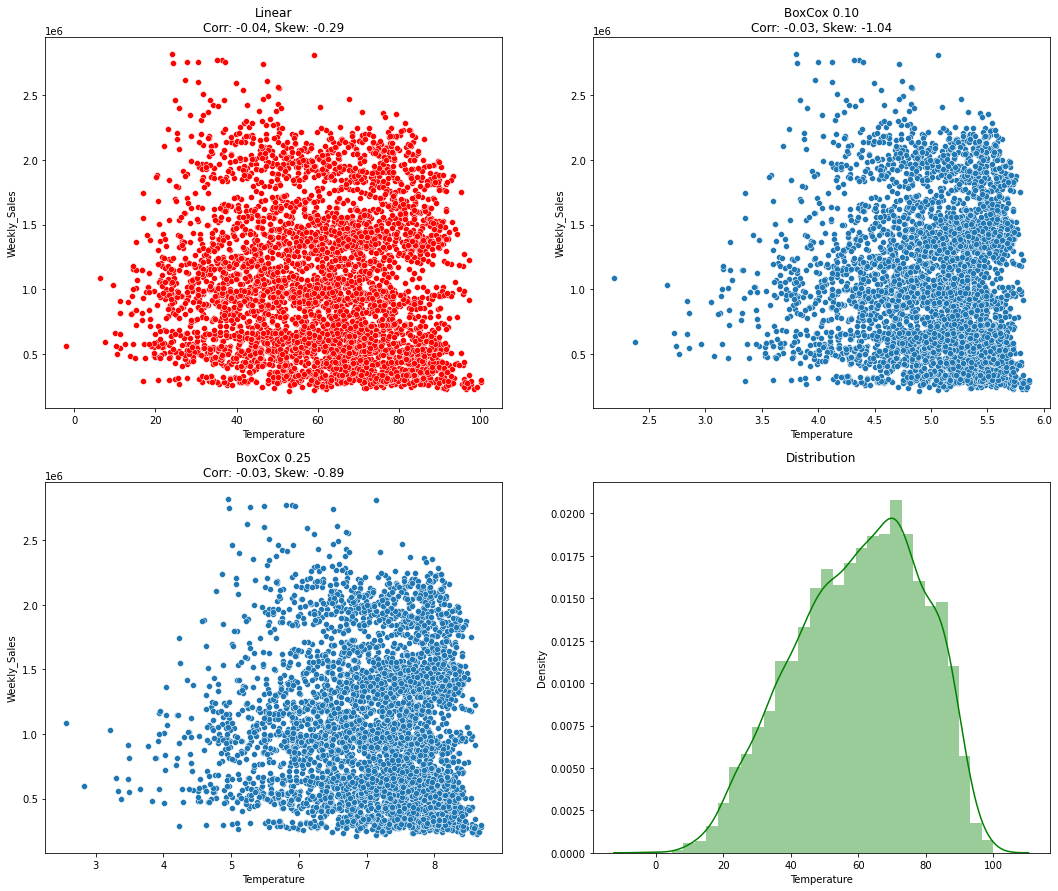

In [18]:
make_continuous_plot('Temperature')

## It aapears that Temperatue is not Correlated to Weekly sales

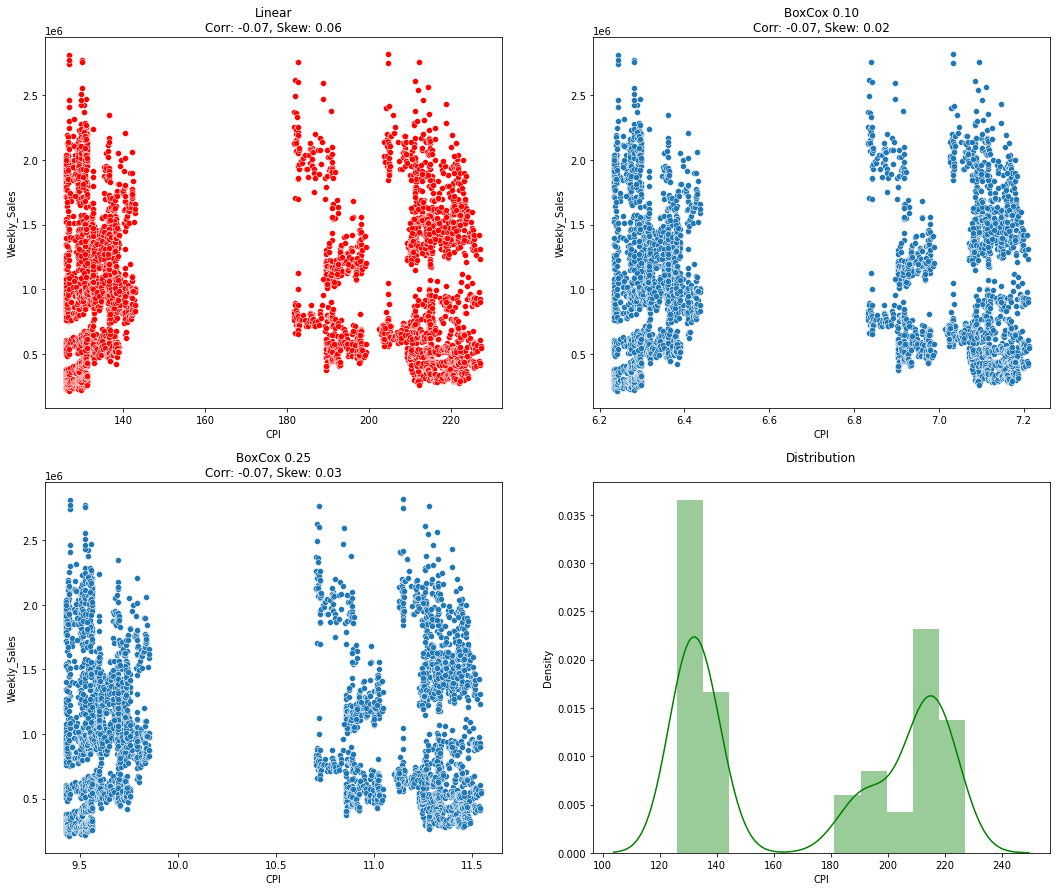

In [19]:
make_continuous_plot('CPI')
## It aapears that CPI is also not Correlated to Weekly sales

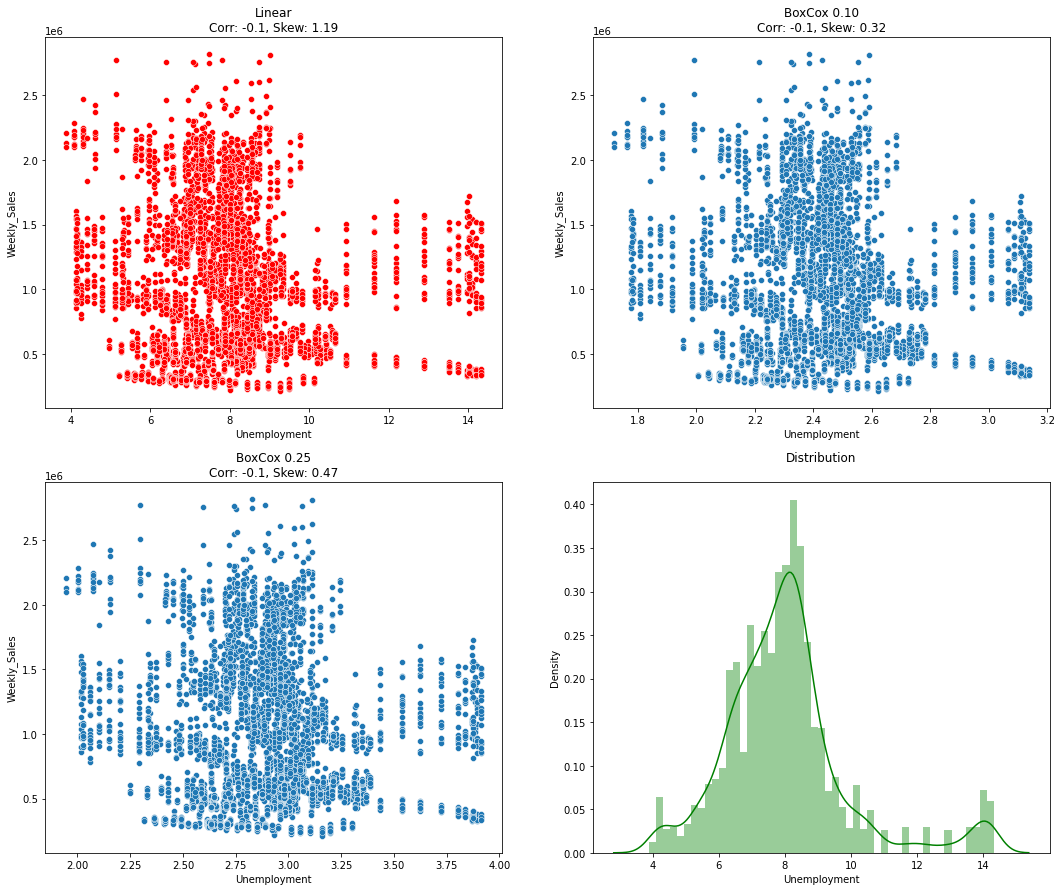

In [24]:
make_continuous_plot('Unemployment')
## It appears that Unemployment is slightly  correlated to Weekly sales

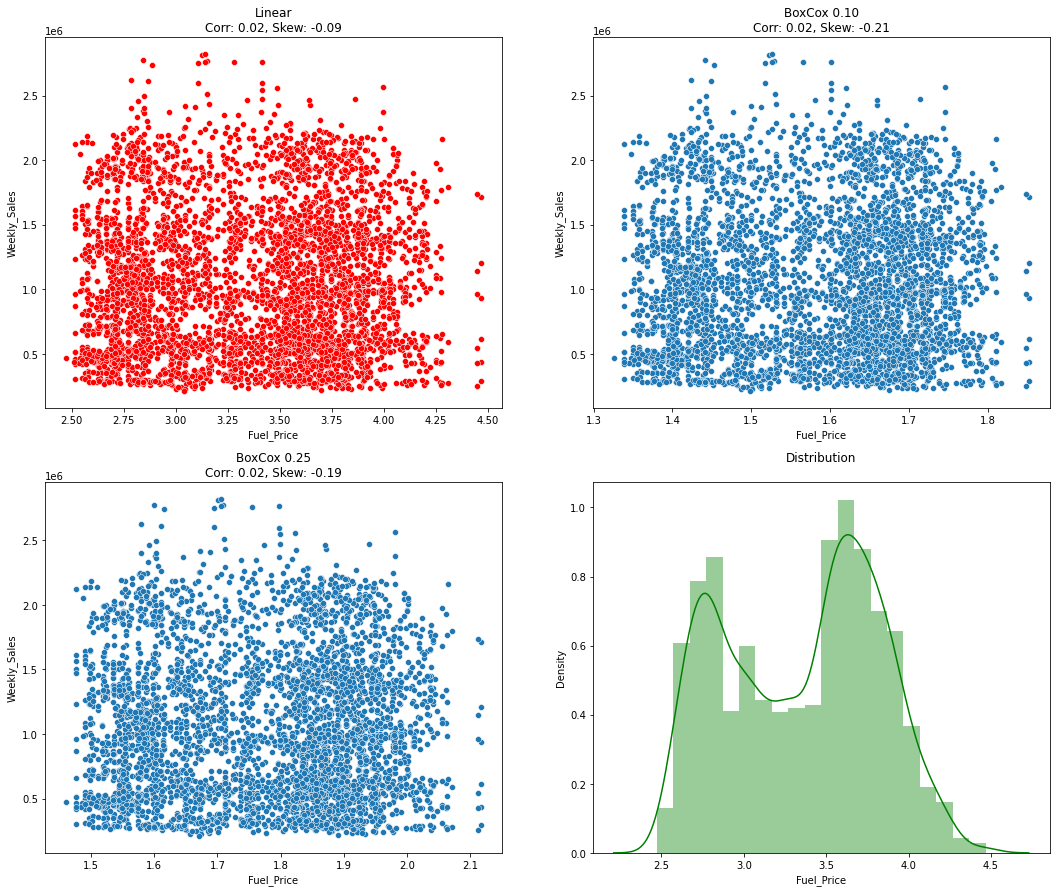

In [20]:
make_continuous_plot('Fuel_Price')
## It aapears that Fuel Price is uncorrelated to Weekly sales

Text(0.5, 1.0, 'Correlation Matrix')

<AxesSubplot:title={'center':'Correlation Matrix'}>

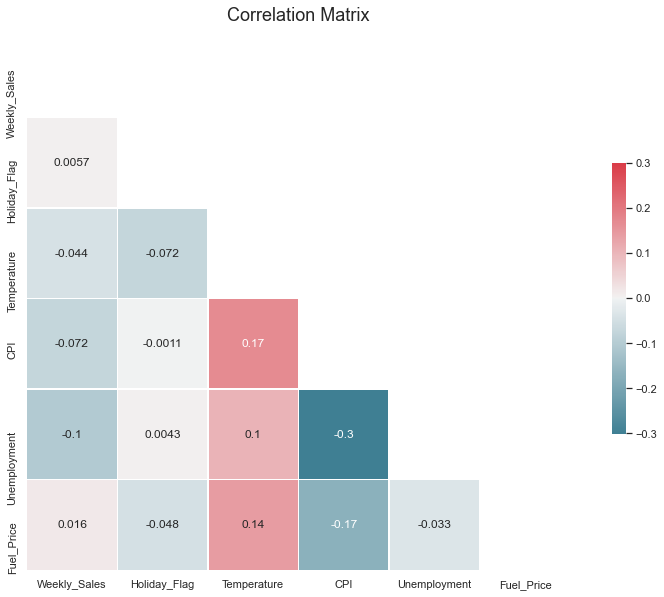

In [58]:
## Plotting heatmap to see the correlation among the input variables and with the target-sales
sns.set(style="white")

corr = df_train.drop('Store',1).corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(15, 10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

## Heatmap shows that all the variables are not sgignificant for Fuel Price calculation

# Creating Lag features

In [22]:
## Calculating lags
df_train_lag = pd.read_sql_query("""SELECT Store,date(substr(Date,7) || '-' || substr(Date,4,2) || '-' || substr(Date,1,2)) as Week_of_Sale,\
Weekly_Sales as Current_Week_Sales,lag(sum(Weekly_Sales),1,0) over (partition by store) as Prev_Week_Sales,\
lag(sum(Weekly_Sales),2,0) over (partition by store) as Prev_2_Week_Sales,\
lag(sum(Weekly_Sales),3,0) over (partition by store) as Prev_3_Week_Sales,lag(sum(Weekly_Sales),4,0) over (partition by store) as Prev_4_Week_Sales\
 FROM Sales_Table where Date <= '2012-11-01' group by Store,date(substr(Date,7) || '-' || substr(Date,4,2) || '-' || substr(Date,1,2)) \
 order by store,Week_of_Sale """, conn)



Text(0.5, 1.0, 'Prev_Week\nCorr: 0.95, Skew: 0.49')

Text(0.5, 1.0, 'Prev_Two_Week\nCorr: 0.92, Skew: 0.46')

Text(0.5, 1.0, 'Prev_Three_Week Corr: 0.89, Skew: 0.44')

Text(0.5, 1.0, 'Prev_Four_Week Corr: 0.87, Skew: 0.42')

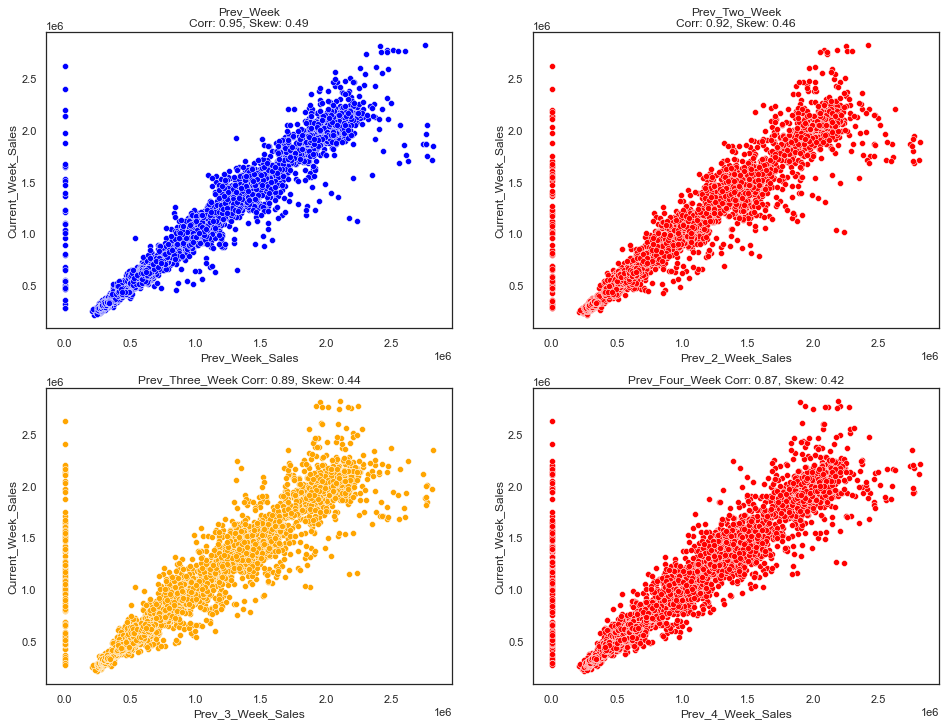

In [23]:
fig = plt.figure(figsize=(16,12))
gs = GridSpec(2,2)
    
j = sns.scatterplot(y=df_train_lag['Current_Week_Sales'], 
                        x=df_train_lag['Prev_Week_Sales'], ax=fig.add_subplot(gs[0,0]), color = 'blue')

plt.title('Prev_Week\n' + 'Corr: ' + str(np.round(df_train_lag['Current_Week_Sales'].corr(df_train_lag['Prev_Week_Sales']),2)) + ', Skew: ' + 
               str(np.round(stats.skew(df_train_lag['Prev_Week_Sales'], nan_policy='omit'),2)))

j = sns.scatterplot(y=df_train_lag['Current_Week_Sales'], 
                        x=df_train_lag['Prev_2_Week_Sales'], ax=fig.add_subplot(gs[0,1]), color = 'red')

plt.title('Prev_Two_Week\n' + 'Corr: ' + str(np.round(df_train_lag['Current_Week_Sales'].corr(df_train_lag['Prev_2_Week_Sales']),2)) + ', Skew: ' + 
               str(np.round(stats.skew(df_train_lag['Prev_2_Week_Sales'], nan_policy='omit'),2)))

j = sns.scatterplot(y=df_train_lag['Current_Week_Sales'], 
                        x=df_train_lag['Prev_3_Week_Sales'], ax=fig.add_subplot(gs[1,0]), color = 'orange')

plt.title( 'Prev_Three_Week ' + 'Corr: ' + str(np.round(df_train_lag['Current_Week_Sales'].corr(df_train_lag['Prev_3_Week_Sales']),2)) + ', Skew: ' + 
               str(np.round(stats.skew(df_train_lag['Prev_3_Week_Sales'], nan_policy='omit'),2)))

j = sns.scatterplot(y=df_train_lag['Current_Week_Sales'], 
                        x=df_train_lag['Prev_4_Week_Sales'], ax=fig.add_subplot(gs[1,1]), color = 'red')

plt.title( 'Prev_Four_Week ' + 'Corr: ' + str(np.round(df_train_lag['Current_Week_Sales'].corr(df_train_lag['Prev_4_Week_Sales']),2)) + ', Skew: ' + 
               str(np.round(stats.skew(df_train_lag['Prev_4_Week_Sales'], nan_policy='omit'),2)))

## The weekly sales are highly correlated with their previous week sales. So we can include lag as important features in prediction


In [29]:
## Calculating Moving avg-- Its taking time so creating using Python
df_train_lag = pd.read_sql_query("""SELECT a.Store,date(substr(a.Date,7) || '-' || substr(a.Date,4,2) || '-' || substr(a.Date,1,2)) as Week_of_Sale,\
avg(b.Weekly_Sales) as MVG  FROM Sales_Table a INNER JOIN  Sales_Table b ON\
 datetime(date(substr(a.Date,7) || '-' || substr(a.Date,4,2) || '-' || substr(a.Date,1,2)), '-3 days') <= date(substr(b.Date,7) || '-' || substr(b.Date,4,2) || '-' || substr(b.Date,1,2))\
 where a.Date <= '2012-11-01' group by a.Store,date(substr(a.Date,7) || '-' || substr(a.Date,4,2) || '-' || substr(a.Date,1,2)) \
 order by a.store,Week_of_Sale """, conn)

df_train_lag


In [24]:
## Calculating Moving avg in different windows using Python
df_train_mvg = pd.read_sql_query("""SELECT Store, Weekly_Sales,substr(Date,7) as Year,\
date(substr(Date,7) || '-' || substr(Date,4,2) || '-' || substr(Date,1,2)) as Week_of_Sale FROM Sales_Table
 where Date <= '2012-11-01' order by store,Week_of_Sale """, conn)

#df_train_mvg

for i in [3,5,7]:
    df_train_mvg["SMA"+str(i)+"_sales_lag01"] = df_train_mvg.groupby(["Store",'Year']).rolling(i).Weekly_Sales.mean().shift(1).values
    df_train_mvg["SMA"+str(i)+"_sales_lag03"] = df_train_mvg.groupby(["Store",'Year']).rolling(i).Weekly_Sales.mean().shift(3).values
    df_train_mvg["SMA"+str(i)+"_sales_lag05"] = df_train_mvg.groupby(["Store",'Year']).rolling(i).Weekly_Sales.mean().shift(10).values
print("Correlation")
df_train_mvg[["Weekly_Sales"]+df_train_mvg.columns[df_train_mvg.columns.str.startswith("SMA")].tolist()].corr()
## It appears that SMA is also highly correlated to sales

Correlation


Weekly_Sales  SMA3_sales_lag01  SMA3_sales_lag03  \
Weekly_Sales            1.0000            0.9695            0.9401   
SMA3_sales_lag01        0.9695            1.0000            0.9929   
SMA3_sales_lag03        0.9401            0.9929            1.0000   
SMA3_sales_lag05        0.8677            0.9019            0.9253   
SMA5_sales_lag01        0.9696            0.9982            0.9979   
SMA5_sales_lag03        0.9392            0.9923            0.9982   
SMA5_sales_lag05        0.8603            0.8979            0.9238   
SMA7_sales_lag01        0.9674            0.9966            0.9982   
SMA7_sales_lag03        0.9359            0.9910            0.9966   
SMA7_sales_lag05        0.8508            0.8902            0.9188   

                  SMA3_sales_lag05  SMA5_sales_lag01  SMA5_sales_lag03  \
Weekly_Sales                0.8677            0.9696            0.9392   
SMA3_sales_lag01            0.9019            0.9982            0.9923   
SMA3_sales_lag03            0.9253            0.9979            0.9982   
SMA3_sales_lag05            1.0000            0.9249            0.9488   
SMA5_sales_lag01            0.9249            1.0000            0.9969   
SMA5_sales_lag03            0.9488            0.9969            1.0000   
SMA5_sales_lag05            0.9982            0.9220            0.9488   
SMA7_sales_lag01            0.9473            0.9991            0.9990   
SMA7_sales_lag03            0.9738            0.9957            0.9991   
SMA7_sales_lag05            0.9966            0.9159            0.9455   

                  SMA5_sales_lag05  SMA7_sales_lag01  SMA7_sales_lag03  \
Weekly_Sales                0.8603            0.9674            0.9359   
SMA3_sales_lag01            0.8979            0.9966            0.9910   
SMA3_sales_lag03            0.9238            0.9982            0.9966   
SMA3_sales_lag05            0.9982            0.9473            0.9738   
SMA5_sales_lag01            0.9220            0.9991            0.9957   
SMA5_sales_lag03            0.9488            0.9990            0.9991   
SMA5_sales_lag05            1.0000            0.9463            0.9763   
SMA7_sales_lag01            0.9463            1.0000            0.9980   
SMA7_sales_lag03            0.9763            0.9980            1.0000   
SMA7_sales_lag05            0.9991            0.9422            0.9753   

                  SMA7_sales_lag05  
Weekly_Sales                0.8508  
SMA3_sales_lag01            0.8902  
SMA3_sales_lag03            0.9188  
SMA3_sales_lag05            0.9966  
SMA5_sales_lag01            0.9159  
SMA5_sales_lag03            0.9455  
SMA5_sales_lag05            0.9991  
SMA7_sales_lag01            0.9422  
SMA7_sales_lag03            0.9753  
SMA7_sales_lag05            1.0000

## Interactive Plotting for different SMA period (of Lag01) using Plotly

In [25]:
import plotly.graph_objs as go
import math #needed for definition of pi
xpoints=np.arange(0, math.pi*2, 0.05)
y1=np.sin(xpoints)
y2=np.cos(xpoints)
fig = go.Figure()

b = df_train_mvg[(df_train_mvg.Store == 1)].set_index("Week_of_Sale")

# Add Traces
fig.add_trace(
go.Scatter(
x=b[b.Year == '2010'].index, y=b[b.Year == '2010']["Weekly_Sales"], 
name='Weekly_Sales'
))

fig.add_trace(
go.Scatter(
x=b[b.Year == '2010'].index, y=b[b.Year == '2010']["SMA3_sales_lag01"], 
name='SMA3_lag01')
)

fig.add_trace(
go.Scatter(
x=b[b.Year == '2010'].index, y=b[b.Year == '2010']["SMA5_sales_lag01"], 
name='SMA5_lag01')
)

fig.add_trace(
go.Scatter(
x=b[b.Year == '2010'].index, y=b[b.Year == '2010']["SMA7_sales_lag01"], 
name='SMA7_lag01')
)

fig.layout.update(
updatemenus=[
go.layout.Updatemenu(
type="buttons", direction="right", active=0, x=0.1, y=1.2,
buttons=list([
#dict(label="first", method="update", args=[{"visible": [True, False,False,False]},{"title": "Weekly_Sales"} ]),
dict(label="SMA3_lag01", method="update", args=[{"visible": [True, True,False,False]},{"title": "SMA3_lag01"}]),
dict(label="SMA5_lag01", method="update", args=[{"visible": [True,False,True,False]},{"title": "SMA5_lag01"}]),
dict(label="SMA7_lag01", method="update", args=[{"visible": [True,False,False,True]},{"title": "SMA7_lag01"}])     
]))
])
fig.show()


Layout({
    'template': '...',
    'updatemenus': [{'active': 0,
                     'buttons': [{'args': [{'visible': [True, True, False, False]}, {'title': 'SMA3_lag01'}],
                                  'label': 'SMA3_lag01',
                                  'method': 'update'},
                                 {'args': [{'visible': [True, False, True, False]}, {'title': 'SMA5_lag01'}],
                                  'label': 'SMA5_lag01',
                                  'method': 'update'},
                                 {'args': [{'visible': [True, False, False, True]}, {'title': 'SMA7_lag01'}],
                                  'label': 'SMA7_lag01',
                                  'method': 'update'}],
                     'direction': 'right',
                     'type': 'buttons',
                     'x': 0.1,
                     'y': 1.2}]
})

## Forcasting using Linear regression
As only the current sales mainly depends on previous sales, so we will build the models based on previous lags and sesonality

In [57]:
## SQL query to get the input and output variables
weekly_sales_df = pd.read_sql_query("""SELECT Store,date(substr(Date,7) || '-' || substr(Date,4,2) || '-' || substr(Date,1,2)) as Week_of_Sale,\
Weekly_Sales as Current_Week_Sales,lag(sum(Weekly_Sales),1,0) over (partition by store) as Prev_Week_Sales,\

lag(sum(Weekly_Sales),2,0) over (partition by store) as Prev_2_Week_Sales,\

lag(sum(Weekly_Sales),3,0) over (partition by store) as Prev_3_Week_Sales,lag(sum(Weekly_Sales),4,0) over (partition by store) as Prev_4_Week_Sales,\
 strftime('%W',(date(substr(Date,7) || '-' || substr(Date,4,2) || '-' || substr(Date,1,2)))) as Week,\
COALESCE(NULLIF((SUBSTR(Date, 4, 2) - 1) / 3, 0), 4) AS Quarter,substr(Date,7) as Year\
 FROM Sales_Table where Date <= '2012-11-01' group by Store,date(substr(Date,7) || '-' || substr(Date,4,2) || '-' || substr(Date,1,2)) \
 order by store,Week_of_Sale """, conn)

weekly_sales_df.shape
weekly_sales_df.head(5)
weekly_sales_df['Week']=weekly_sales_df['Week'].apply(lambda x:int(x))
weekly_sales_df['Quarter']=weekly_sales_df['Quarter'].apply(lambda x:int(x))
weekly_sales_df_copy=weekly_sales_df.copy()

(4275, 10)

Store Week_of_Sale  Current_Week_Sales  Prev_Week_Sales  Prev_2_Week_Sales  \
0      1   2010-02-05        1643690.9000           0.0000             0.0000   
1      1   2010-02-12        1641957.4400     1643690.9000             0.0000   
2      1   2010-02-19        1611968.1700     1641957.4400       1643690.9000   
3      1   2010-03-05        1554806.6800     1611968.1700       1641957.4400   
4      1   2010-03-12        1439541.5900     1554806.6800       1611968.1700   

   Prev_3_Week_Sales  Prev_4_Week_Sales Week  Quarter  Year  
0             0.0000             0.0000   05        4  2010  
1             0.0000             0.0000   06        4  2010  
2             0.0000             0.0000   07        4  2010  
3       1643690.9000             0.0000   09        4  2010  
4       1641957.4400       1643690.9000   10        4  2010

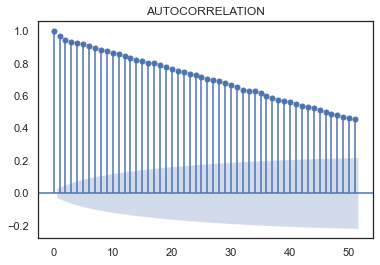

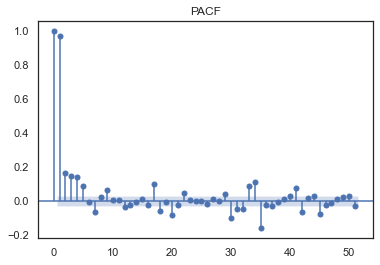

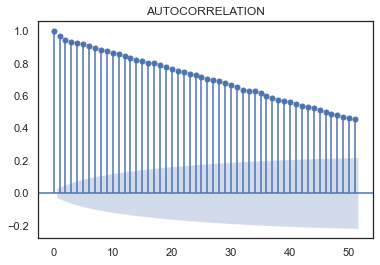

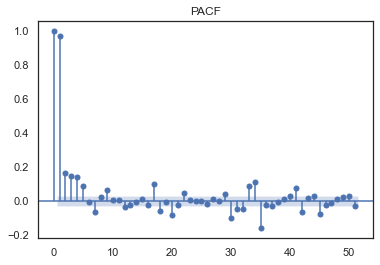

In [27]:
## Checking the correlation with LAGS
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(weekly_sales_df.Current_Week_Sales, lags=51, title = "AUTOCORRELATION")
sm.graphics.tsa.plot_pacf(weekly_sales_df.Current_Week_Sales, lags=51, title = "PACF")
## PACF shows lag-1 is the prominant one

## Forecasting for next week sale

In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

In [73]:
## Training on 2010 and 2011 data
weekly_sales_df=weekly_sales_df_copy.copy()


weekly_sales_df=weekly_sales_df.set_index(['Store','Week_of_Sale'])

## Training on 2010 and 2011
weekly_sales_df=weekly_sales_df[weekly_sales_df.Year.isin(['2010','2011'])]

weekly_sales_df = weekly_sales_df.reset_index('Store')

## Creating X and Y variables for training the model
X = weekly_sales_df.loc[:, ['Store','Prev_Week_Sales','Week','Quarter']].dropna()  # features
y = weekly_sales_df.loc[:, 'Current_Week_Sales']  # target
#y, X = y.align(X, join='inner')  # drop corresponding values in target

# YOUR CODE HERE: Create a LinearRegression instance and fit it to X and y.
model_next_week = LinearRegression()
model_next_week.fit(X, y)

# # YOUR CODE HERE: Create Store the fitted values as a time series with
# # the same time index as the training data
#y_pred=model.predict(X)
y_pred = pd.DataFrame(model_next_week.predict(X), index=X.index)
#y_pred.rename(columns={0:'Current_Week_Sales'},inplace=True)
#print(f"% Train Error for year 2010 = {100*mean_absolute_error(y,y_pred)/y.mean():.2f}%")
y = pd.DataFrame(y)
y_pred['Store']=X.Store.to_list()
y_pred=y_pred.reset_index('Week_of_Sale').set_index(['Store','Week_of_Sale']).unstack(['Store'])

y['Store']=X.Store.to_list()
y=y.reset_index('Week_of_Sale').set_index(['Store','Week_of_Sale']).unstack(['Store'])

print(f"MAE in training  = {mean_absolute_error(y,y_pred):.2f}")
print(f"% Error in training  = {100*mean_absolute_percentage_error(y,y_pred):.2f}%")
print(f"% Accuracy Train = {100-100*mean_absolute_percentage_error(y,y_pred):.2f}%")

LinearRegression()

MAE in training  = 97347.42
% Error in training  = 11.17%
% Accuracy Train = 88.83%


Text(0, 0.5, 'Weekly Sales')

Text(0.5, 1.0, ' Actual vs Predicted Total-Next week sales(Train)')

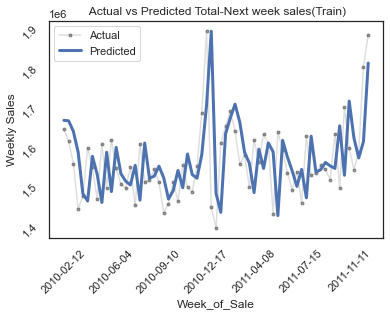

In [74]:
plot_params={'color': '0.75',
 'style': '.-',
 'markeredgecolor': '0.25',
 'markerfacecolor': '0.25',
 'legend': True}
ax = y[y.index!='2010-02-05'].loc(axis=1)['Current_Week_Sales',1].plot(**plot_params, alpha=0.5)
ax = y_pred[y_pred.index!='2010-02-05'].loc(axis=1)[0, 1].plot(ax=ax, linewidth=3)
ax.set_ylabel('Weekly Sales')
ax.legend(['Actual','Predicted'])
ax.set_title(' Actual vs Predicted Total-Next week sales(Train)');
ax.tick_params(rotation=45)

## It shows we are able to capure the trend properly 

In [75]:
## Testing on 2012 year data

weekly_sales_df=weekly_sales_df_copy.copy()

weekly_sales_df=weekly_sales_df.set_index(['Store','Week_of_Sale'])

weekly_sales_df=weekly_sales_df[weekly_sales_df.Year.isin(['2012'])]

weekly_sales_df = weekly_sales_df.reset_index('Store')

## Creating X and Y variables for training the model
X_test = weekly_sales_df.loc[:, ['Store','Prev_Week_Sales','Week','Quarter']].dropna()  # features
y_test = weekly_sales_df.loc[:, 'Current_Week_Sales']  # target
#y, X = y.align(X, join='inner')  # drop corresponding values in target


y_pred_test = pd.DataFrame(model_next_week.predict(X_test), index=X_test.index)
#y_pred_test.rename(columns={0:'Current_Week_Sales'},inplace=True)
#print(f"% Train Error for year 2010 = {100*mean_absolute_error(y,y_pred)/y.mean():.2f}%")
y_test = pd.DataFrame(y_test)
y_pred_test['Store']=X_test.Store.to_list()
y_pred_test=y_pred_test.reset_index('Week_of_Sale').set_index(['Store','Week_of_Sale']).unstack(['Store'])

y_test['Store']=X_test.Store.to_list()
y_test=y_test.reset_index('Week_of_Sale').set_index(['Store','Week_of_Sale']).unstack(['Store'])

print(f"MAE in test  = {mean_absolute_error(y_test,y_pred_test):.2f}")
print(f"% Error in Test(2012 data)  = {100*mean_absolute_percentage_error(y_test,y_pred_test):.2f}%")
print(f"% Accuracy Test(2012 data) = {100-100*mean_absolute_percentage_error(y_test,y_pred_test):.2f}%")

MAE in test  = 88037.50
% Error in Test(2012 data)  = 10.26%
% Accuracy Test(2012 data) = 89.74%


Text(0, 0.5, 'Weekly Sales')

Text(0.5, 1.0, ' Actual vs Predicted Total-Next week sales(Test)')

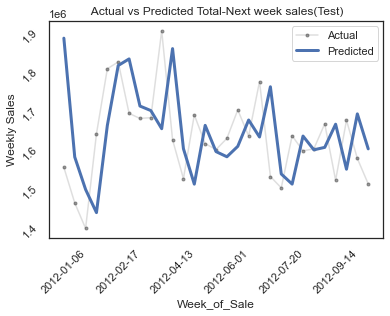

In [76]:
ax = y_test[y_test.index!='2010-02-05'].loc(axis=1)['Current_Week_Sales',1].plot(**plot_params, alpha=0.5)
ax = y_pred_test[y_pred_test.index!='2010-02-05'].loc(axis=1)[0, 1].plot(ax=ax, linewidth=3)
ax.set_ylabel('Weekly Sales')
ax.legend(['Actual','Predicted'])
ax.set_title(' Actual vs Predicted Total-Next week sales(Test)');
ax.tick_params(rotation=45)
## It shows we are able to capure the trend but with lag. Some new seasonality paramater needs to be introduced

## Forecasting for more next month i.e 4 weeks- Multi-Step

In [33]:
## Function to create lags
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


In [77]:

## Training on 2010 and 2011

weekly_sales_df=weekly_sales_df_copy.copy()

weekly_sales_df=weekly_sales_df[weekly_sales_df.Year.isin(['2010','2011'])]

y = make_multistep_target(weekly_sales_df.groupby('Store')['Current_Week_Sales'], steps=4)
weekly_sales_df=weekly_sales_df.set_index(['Store','Week_of_Sale'])



weekly_sales_df = weekly_sales_df.reset_index('Store')

## Creating X and Y variables for training the model
X = weekly_sales_df.loc[:, ['Store','Prev_Week_Sales','Week','Quarter']].dropna()  # features

y.index=X.index

X=X[y.isna().sum(axis=1).replace({0:True, 1:False,2:False,3:False})]
y=y.dropna()
#y, X = y.align(X, join='inner', axis=0)  # drop corresponding values in target

# # YOUR CODE HERE: Create a LinearRegression instance and fit it to X and y.
model_next_4_weeks = LinearRegression()
model_next_4_weeks.fit(X, y)

y_pred = pd.DataFrame(model_next_4_weeks.predict(X), index=X.index)
y_pred['Store']=X.Store.to_list()
y_pred=y_pred.reset_index('Week_of_Sale').set_index(['Store','Week_of_Sale']).unstack(['Store'])

y = pd.DataFrame(y)
y['Store']=X.Store.to_list()
y=y.reset_index('Week_of_Sale').set_index(['Store','Week_of_Sale']).unstack(['Store'])

print(f"MAE in training  = {mean_absolute_error(y,y_pred):.2f}")
print(f"% Error in training  = {100*mean_absolute_percentage_error(y,y_pred):.2f}%")
print(f"% Accuracy Train = {100-100*mean_absolute_percentage_error(y,y_pred):.2f}%")

LinearRegression()

MAE in training  = 111556.01
% Error in training  = 12.72%
% Accuracy Train = 87.28%


Text(0, 0.5, 'Weekly Sales')

Text(0.5, 1.0, ' Actual vs Predicted Total-Next month sales(Train)')

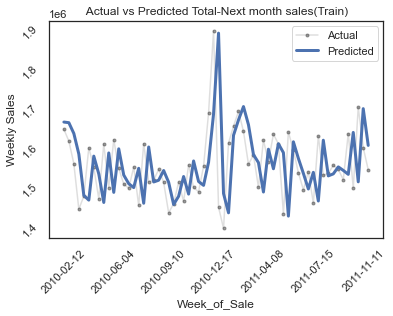

In [78]:
ax = y[y.index!='2010-02-05'].loc(axis=1)['y_step_1',1].plot(**plot_params, alpha=0.5)
ax = y_pred[y_pred.index!='2010-02-05'].loc(axis=1)[0, 1].plot(ax=ax, linewidth=3)
ax.set_ylabel('Weekly Sales')
ax.legend(['Actual','Predicted'])
ax.set_title(' Actual vs Predicted Total-Next month sales(Train)');
ax.tick_params(rotation=45)

## It shows we are able to capure the trend properly 

In [79]:
## Testing on 2012

weekly_sales_df=weekly_sales_df_copy.copy()

weekly_sales_df=weekly_sales_df[weekly_sales_df.Year.isin(['2012'])]
weekly_sales_df.shape

y_test = make_multistep_target(weekly_sales_df.groupby('Store')['Current_Week_Sales'], steps=4)
weekly_sales_df=weekly_sales_df.set_index(['Store','Week_of_Sale'])



weekly_sales_df = weekly_sales_df.reset_index('Store')

## Creating X and Y variables for training the model
X_test = weekly_sales_df.loc[:, ['Store','Prev_Week_Sales','Week','Quarter']].dropna()  # features

y_test.index=X_test.index

X_test=X_test[y_test.isna().sum(axis=1).replace({0:True, 1:False,2:False,3:False})]
y_test=y_test.dropna()


y_pred_test = pd.DataFrame(model_next_4_weeks.predict(X_test), index=X_test.index)
y_pred_test['Store']=X_test.Store.to_list()
y_pred_test=y_pred_test.reset_index('Week_of_Sale').set_index(['Store','Week_of_Sale']).unstack(['Store'])

y_test = pd.DataFrame(y_test)
y_test['Store']=X_test.Store.to_list()
y_test=y_test.reset_index('Week_of_Sale').set_index(['Store','Week_of_Sale']).unstack(['Store'])

print(f"MAE in test  = {mean_absolute_error(y_test,y_pred_test):.2f}")
print(f"% Error in Test(2012 data)  = {100*mean_absolute_percentage_error(y_test,y_pred_test):.2f}%")
print(f"% Accuracy Test(2012 data) = {100-100*mean_absolute_percentage_error(y_test,y_pred_test):.2f}%")


(1305, 10)

MAE in test  = 99945.70
% Error in Test(2012 data)  = 11.53%
% Accuracy Test(2012 data) = 88.47%


Text(0, 0.5, 'Weekly Sales')

Text(0.5, 1.0, ' Actual vs Predicted Total-Next month sales(Test)')

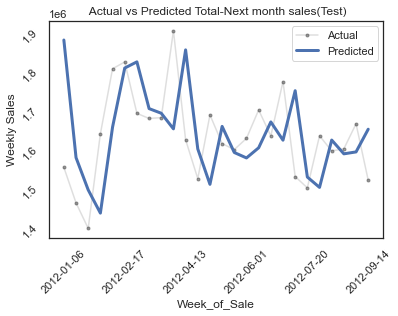

In [80]:
ax = y_test[y_test.index!='2010-02-05'].loc(axis=1)['y_step_1',1].plot(**plot_params, alpha=0.5)
ax = y_pred_test[y_pred_test.index!='2010-02-05'].loc(axis=1)[0, 1].plot(ax=ax, linewidth=3)
ax.set_ylabel('Weekly Sales')
ax.legend(['Actual','Predicted'])
ax.set_title(' Actual vs Predicted Total-Next month sales(Test)');
ax.tick_params(rotation=45)
## It shows we are able to capure the trend but with lag. Some new seasonality paramater needs to be introduced

In [38]:
## Saving the model for web connection
pickle.dump(model_next_week, open('C:\\Users\\npand\\OneDrive\\Desktop\\MS_Course\\ES503\\Project_Doc\model_next_week.pkl','wb'))

pickle.dump(model_next_4_weeks, open('C:\\Users\\npand\\OneDrive\\Desktop\\MS_Course\\ES503\\Project_Doc\model_next_4_weeks.pkl','wb'))


## Connecting to Web is done using Flask- Seperate Python Program is written for it